In [40]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.metrics import classification_report, confusion_matrix

In [41]:
import os
data_path = os.path.join(os.path.dirname(os.getcwd()),'data')

In [42]:
fraudtrain = pd.read_csv(os.path.join(data_path,"fraudTrain.csv")).iloc[:,1:]

fraudtrain.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [43]:
fraudtrain.shape

(1296675, 22)

In [44]:
fraudtrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1296675 non-null  object 
 1   cc_num                 1296675 non-null  int64  
 2   merchant               1296675 non-null  object 
 3   category               1296675 non-null  object 
 4   amt                    1296675 non-null  float64
 5   first                  1296675 non-null  object 
 6   last                   1296675 non-null  object 
 7   gender                 1296675 non-null  object 
 8   street                 1296675 non-null  object 
 9   city                   1296675 non-null  object 
 10  state                  1296675 non-null  object 
 11  zip                    1296675 non-null  int64  
 12  lat                    1296675 non-null  float64
 13  long                   1296675 non-null  float64
 14  city_pop          

I am wanting to check the range of the transfering date time before doing age calculation.

In [57]:
cc_counts = fraudtrain['cc_num'].value_counts(ascending=False)
cc_counts[cc_counts > 1].index

Int64Index([       571365235126, 4512828414983801773,      36722699017270,
                213112402583773,    3545109339866548,    6534628260579800,
               6011367958204270,    2720433095629877,    6011438889172900,
               6011109736646996,
            ...
               4734310647841293,    3545578418030657, 4714017207228610634,
               6577777028615915,    6011732631674654,     180097223252063,
               4225628813173670,        501894933032,       4975457191020,
                340187018810220],
           dtype='int64', length=983)

In [7]:
print(max(fraudtrain['trans_date_trans_time']))
print(min(fraudtrain['trans_date_trans_time']))

2020-06-21 12:13:37
2019-01-01 00:00:18


In [9]:
#Converting the dob to an appropriate datetime format
fraudtrain['dob'] = pd.to_datetime(fraudtrain['dob'])

In [10]:
#Assuming current date is the end of 2020
currentdate = dt.datetime(2020,12,31)
fraudtrain['age'] = currentdate.year - fraudtrain['dob'].dt.year
fraudtrain['age'] = fraudtrain['age'].astype(int)

In [11]:
# Now lets select columns that I think are possibly useful - i know this is highly debatable but in interest of time i decided to go ahead with this
selectedcolumns = ['category','amt','gender','job','merchant', 'age','is_fraud']
fraudtrain_reduced = fraudtrain[selectedcolumns]

fraudtrain_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 7 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   category  1296675 non-null  object 
 1   amt       1296675 non-null  float64
 2   gender    1296675 non-null  object 
 3   job       1296675 non-null  object 
 4   merchant  1296675 non-null  object 
 5   age       1296675 non-null  int64  
 6   is_fraud  1296675 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 69.3+ MB


I am just curious about the breakdown for some of the categorical features, especially on the gender and the merchant categories. I believe the distribution of some of these categorical fields are quite highly skewed.

In [12]:
cat_group = fraudtrain_reduced.groupby(['category']).size().reset_index()
cat_group.columns = ['category','category counts']
cat_group['Percentage'] = round((100 * cat_group['category counts']/cat_group['category counts'].sum()),2)
cat_group


,category,category counts,Percentage
0,entertainment,94014,7.25
1,food_dining,91461,7.05
2,gas_transport,131659,10.15
3,grocery_net,45452,3.51
4,grocery_pos,123638,9.54
5,health_fitness,85879,6.62
6,home,123115,9.49
7,kids_pets,113035,8.72
8,misc_net,63287,4.88
9,misc_pos,79655,6.14


In [13]:
fraud_group = fraudtrain_reduced.groupby(['is_fraud']).size().reset_index()
fraud_group.columns = ['is_fraud','fraud counts']
fraud_group['Percentage'] = round((100 * fraud_group['fraud counts']/fraud_group['fraud counts'].sum()),2)
fraud_group

,is_fraud,fraud counts,Percentage
0,0,1289169,99.42
1,1,7506,0.58


In [14]:
gender_group = fraudtrain_reduced.groupby(['gender']).size().reset_index()
gender_group.columns = ['gender', 'gender counts']
gender_group['Percentage'] = round((100 * gender_group['gender counts']/gender_group['gender counts'].sum()),2)
gender_group


,gender,gender counts,Percentage
0,F,709863,54.74
1,M,586812,45.26


In [15]:
7506/(1289169 + 7506)

0.005788651743883394

Visual view of some of the selected numerical features

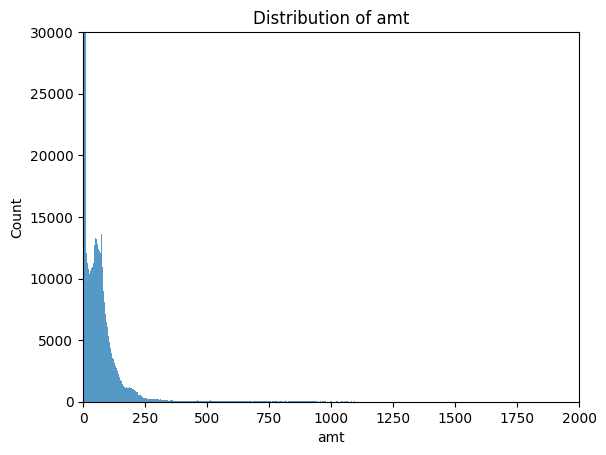

In [15]:
g = sns.histplot(data=fraudtrain, x='amt')
g = g.set(xlim=(0,2000),ylim=(0,30000))
plt.title('Distribution of amt')
plt.show(g)

In [16]:
print(max(fraudtrain['amt']))
print(min(fraudtrain['amt']))

28948.9
1.0


Text(0.5, 1.0, 'Distribution of age')

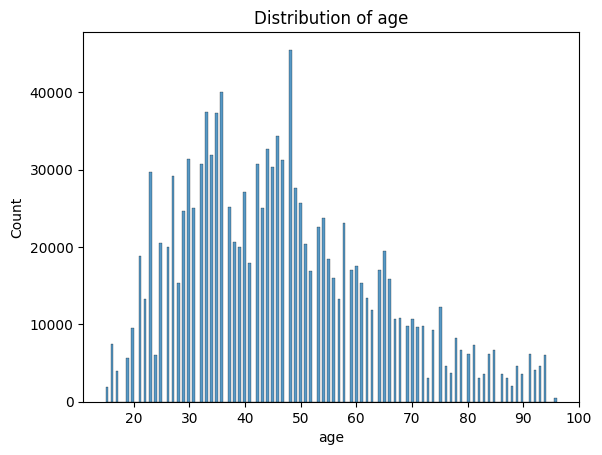

In [17]:
sns.histplot(data=fraudtrain, x='age')
plt.title('Distribution of age')

we can conclude that the amount field is very highly skewed, with some very extreme outliers. we would be needing to do standardscaling to remove the effects of outliers and *force" these fields to conform to a normal distribution.

In [16]:
X = fraudtrain_reduced.drop(columns=['is_fraud'],axis=1)
y = fraudtrain_reduced['is_fraud']

print(X.shape)
print(y.shape)

(1296675, 6)
(1296675,)


In [17]:
num_columns = X.select_dtypes(include=['float64','int64']).columns
cat_columns = X.select_dtypes(include=['object']).columns

In [18]:
print(num_columns)
print(cat_columns)

Index(['amt', 'age'], dtype='object')
Index(['category', 'gender', 'job', 'merchant'], dtype='object')


### creating the pre processing pipelines - these are important!

In [19]:
cat_transformer = make_pipeline(OneHotEncoder(handle_unknown='ignore',sparse=False))
num_transformer = make_pipeline(StandardScaler())

preprocessor = make_pipeline(ColumnTransformer([('num_transformer',num_transformer,num_columns),('cat_transformer',cat_transformer,cat_columns)],
                                               remainder='passthrough'))

In [20]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=123)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(907672, 6)
(389003, 6)
(907672,)
(389003,)


In [25]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

print(X_train.shape)
print(X_test.shape)

/Users/eugenechua/.pyenv/versions/3.10.6/envs/fraud/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(907672, 1205)
(389003, 1205)


In [105]:
#Fitting the random forest classifier
RFmodel = RandomForestClassifier(random_state=123, n_jobs=-1)
RFmodel.fit(X_train,y_train)

RF_pred = RFmodel.predict(X_test)

random forest took more than **6 hours** to run..and I decided to go ahead to try out the faster gradient boosting algorithms.

In [26]:
#Fitting the xgboost classifier!

XGBmodel = XGBClassifier(random_state=123, n_jobs=-1)
XGBmodel.fit(X_train, y_train)

XGB_pred = XGBmodel.predict(X_test)

In [18]:
## loading the XGB model here just in case m kernal crashes
import pickle
model_in = open('/Users/eugenechua/Downloads/skillsfuture_interview/fraud/Fraud-Analysis/XGB_classifier.pkl','rb')
XGBmodel = pickle.load(model_in)

XGB_pred = XGBmodel.predict(X_test)

In [27]:

cf_matrix = confusion_matrix(y_test, XGB_pred)
print(cf_matrix)

[[386418    332]
 [   700   1553]]


In [37]:
#Accuracy calculations
print((1553 + 386418)/(386418 + 332 + 700 + 1553))

#precision calculations
print(1553/(1553+332))

#recall calculations
print(1553/(1553+700))


0.9973470641614589
0.8238726790450929
0.6893031513537505


In [39]:
386418 + 1553

387971

In [29]:
print(classification_report(y_test,XGB_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    386750
           1       0.82      0.69      0.75      2253

    accuracy                           1.00    389003
   macro avg       0.91      0.84      0.87    389003
weighted avg       1.00      1.00      1.00    389003



This baseline result is slightly better than the earlier model that I have ran without the inclusion of age as a variable. Baseline precision and recall was 81% and 66% respectively.

The Recall metric (tp/(tp + fn)) might be more relevant here as missing out on the *false negative* might be more expensive to the organisation than missing out on the *false positive*.

In [30]:
XGBproba = XGBmodel.predict_proba(X_test)

In [31]:
XGBproba_boolean = (XGBproba[:,1] > 0.4)
print(classification_report(y_test,XGBproba_boolean))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    386750
           1       0.79      0.73      0.76      2253

    accuracy                           1.00    389003
   macro avg       0.89      0.87      0.88    389003
weighted avg       1.00      1.00      1.00    389003



Techinically, I might feel more comfortable with this with the precision and recall metrics both more balanced out.

### lightgbm!

In [32]:
lightGBMmodel = LGBMClassifier(random_state=123, n_jobs=-1)
lightGBMmodel.fit(X_train, y_train)

lightGBM_pred = lightGBMmodel.predict(X_test)

In [33]:
cf_matrix = confusion_matrix(y_test, lightGBM_pred)
print(cf_matrix)

[[386126    624]
 [   952   1301]]


In [34]:
print(classification_report(y_test,lightGBM_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    386750
           1       0.68      0.58      0.62      2253

    accuracy                           1.00    389003
   macro avg       0.84      0.79      0.81    389003
weighted avg       1.00      1.00      1.00    389003



lightgbm base performance off the blocks is nothing nowhere near XGboost. Doing hyperparameter tuning might lead to a better performance, but in interest of time, I will just stick to XGBoost.

In [35]:
import pickle

model_out = open('XGB_classifier.pkl','wb')
pickle.dump(XGBmodel, model_out)
model_out.close()

In [36]:
preprocessor_out = open('preprocessor.pkl', 'wb')
pickle.dump(preprocessor, preprocessor_out)
preprocessor_out.close()

In [62]:
preprocessor

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_transformer',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  Index(['amt', 'age'], dtype='object')),
                                                 ('cat_transformer',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['category', 'gender', 'job', 'merchant'], dtype='object'))]))])

In [37]:
def create_preprocessor(input_df: pd.DataFrame):
    
    num_columns = 'amt'
    cat_columns = ['category', 'gender', 'job', 'merchant']
    
    cat_transformer = make_pipeline(OneHotEncoder(handle_unknown='ignore',sparse=False))
    num_transformer = make_pipeline(MinMaxScaler())
    
    preprocessor = make_pipeline(ColumnTransformer([('num_transformer',num_transformer,num_columns),('cat_transformer',cat_transformer,cat_columns)],
                                               remainder='passthrough'))
    
    return preprocessor
    
    
    

In [44]:
X.head()

,category,amt,gender,job,merchant,age
0,misc_net,4.97,F,"Psychologist, counselling","fraud_Rippin, Kub and Mann",32
1,grocery_pos,107.23,F,Special educational needs teacher,"fraud_Heller, Gutmann and Zieme",42
2,entertainment,220.11,M,Nature conservation officer,fraud_Lind-Buckridge,58
3,gas_transport,45.00,M,Patent attorney,"fraud_Kutch, Hermiston and Farrell",53
4,misc_pos,41.96,M,Dance movement psychotherapist,fraud_Keeling-Crist,34


In [40]:
X.to_csv('/Users/eugenechua/Downloads/skillsfuture_interview/fraud/data/X_data.csv', index=False)

In [46]:
fraudtrain_reduced[fraudtrain_reduced['is_fraud']==1]

,category,amt,gender,job,merchant,age,is_fraud
2449,grocery_pos,281.06,M,Soil scientist,fraud_Rutherford-Mertz,32,1
2472,gas_transport,11.52,F,Horticultural consultant,"fraud_Jenkins, Hauck and Friesen",60,1
2523,grocery_pos,276.31,F,Horticultural consultant,fraud_Goodwin-Nitzsche,60,1
2546,gas_transport,7.03,M,Soil scientist,fraud_Erdman-Kertzmann,32,1
2553,grocery_pos,275.73,F,Horticultural consultant,fraud_Koepp-Parker,60,1
...,...,...,...,...,...,...,...
1295399,shopping_net,977.01,F,"Librarian, public",fraud_Kassulke PLC,34,1
1295491,shopping_net,1210.91,F,"Librarian, public",fraud_Schumm PLC,34,1
1295532,gas_transport,10.24,M,Herbalist,"fraud_Tillman, Dickinson and Labadie",26,1
1295666,gas_transport,21.69,F,Cytogeneticist,fraud_Corwin-Collins,51,1


In [47]:
#lets try a prediction here simulating a person inputing and then dishing out predictions

input_df = X[:1]
X_processed = preprocessor.transform(input_df)

X_processed.shape





(1, 1205)

In [48]:
new_pred = XGBmodel.predict(X_processed)

new_pred

array([0])

Lets look at the actual test data

In [19]:
fraudtest = pd.read_csv(os.path.join(data_path,"fraudTest.csv")).iloc[:,1:]

fraudtest.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,Titusville,...,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,Falmouth,...,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


In [20]:
## let us look at those fraudulent transactions.

fraudtest[fraudtest['is_fraud']==1].head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
1685,2020-06-21 22:06:39,3560725013359375,fraud_Hamill-D'Amore,health_fitness,24.84,Brooke,Smith,F,63542 Luna Brook Apt. 012,Notrees,...,31.8599,-102.7413,23,Cytogeneticist,1969-09-15,16bf2e46c54369a8eab2214649506425,1371852399,32.575873,-102.604290,1
1767,2020-06-21 22:32:22,6564459919350820,"fraud_Rodriguez, Yost and Jenkins",misc_net,780.52,Douglas,Willis,M,619 Jeremy Garden Apt. 681,Benton,...,42.5545,-90.3508,1306,Public relations officer,1958-09-10,ab4b379d2c0c9c667d46508d4e126d72,1371853942,42.461127,-91.147148,1
1781,2020-06-21 22:37:27,6564459919350820,fraud_Nienow PLC,entertainment,620.33,Douglas,Willis,M,619 Jeremy Garden Apt. 681,Benton,...,42.5545,-90.3508,1306,Public relations officer,1958-09-10,47a9987ae81d99f7832a54b29a77bf4b,1371854247,42.771834,-90.158365,1
1784,2020-06-21 22:38:55,4005676619255478,"fraud_Heathcote, Yost and Kertzmann",shopping_net,1077.69,William,Perry,M,458 Phillips Island Apt. 768,Denham Springs,...,30.4590,-90.9027,71335,Herbalist,1994-05-31,fe956c7e4a253c437c18918bf96f7b62,1371854335,31.204974,-90.261595,1
1857,2020-06-21 23:02:16,3560725013359375,fraud_Hermann and Sons,shopping_pos,842.65,Brooke,Smith,F,63542 Luna Brook Apt. 012,Notrees,...,31.8599,-102.7413,23,Cytogeneticist,1969-09-15,f6838c01f5d2262006e6b71d33ba7c6d,1371855736,31.315782,-102.736390,1


Let us also try with data from the **real** test set with a record that was actually a fraud!

In [21]:
fraudtest['dob'] = pd.to_datetime(fraudtest['dob'])


currentdate = dt.datetime(2020,12,31)
fraudtest['age'] = currentdate.year - fraudtest['dob'].dt.year
fraudtest['age'] = fraudtest['age'].astype(int)

In [36]:
realfraud = fraudtest[fraudtest['is_fraud']==1][2:3]

realfraud_reduced = realfraud[selectedcolumns] 

realfraud_reduced = realfraud_reduced.drop(columns=['is_fraud'],axis=1)

realfraud_reduced



,category,amt,gender,job,merchant,age
1781,entertainment,620.33,M,Public relations officer,fraud_Nienow PLC,62


In [86]:
X_preprocessed = preprocessor.transform(realfraud_reduced)

XGBmodel.predict(X_preprocessed)

array([1])

Oh the model actually predicted a fraud on the actual testing set!

In [50]:
print(max(fraudtrain['trans_date_trans_time']))
print(min(fraudtrain['trans_date_trans_time']))

2020-06-21 12:13:37
2019-01-01 00:00:18


In [52]:
print(max(fraudtest['trans_date_trans_time']))
print(min(fraudtest['trans_date_trans_time']))

2020-12-31 23:59:34
2020-06-21 12:14:25


### Areas of improvement.

* I took a leap of faith and simply based on intuition, I selected a few fields that I thought would be relevant to the model and went for it. There could be other features that could be a potentially better predictor of fraud? I can't affirm this possibility.

* Just running the base model without any hyperparameter tuning or cross validation already took me 3 hours. I believe if there the hyperparameters are better optimized, we could have gotten better precison/recall scores.

* This is a highly unbalanced data set, with just 0.5% of the transactions identified as actual fraudulent cases. I have not tried upsampling the *underrepresented* class through any data augmentation techniques (SMOTE etc..) But however do bear in mind that there are some drawbacks into using SMOTE --> creating quite a fair bit of noisy data points in the feature space that it is expanding on.

### ML Ops portion

In the interest of time, I would be focusing more on target and data drift which are both key drivers to **monitor** the model in the context of model drifting. I would be using the package evidently to help me with this. the 2 key things to take note of would be
* Concept Drifting
* Data Drifting

In [60]:
from evidently.dashboard import Dashboard
from evidently.tabs import DataDriftTab, CatTargetDriftTab

/Users/eugenechua/.pyenv/versions/3.10.6/envs/fraud/lib/python3.10/site-packages/evidently/analyzers/__init__.py:3: UserWarning: analyzers are deprecated, use metrics instead
  warnings.warn("analyzers are deprecated, use metrics instead")
/Users/eugenechua/.pyenv/versions/3.10.6/envs/fraud/lib/python3.10/site-packages/evidently/dashboard/__init__.py:8: UserWarning: dashboards are deprecated, use metrics instead
  warnings.warn("dashboards are deprecated, use metrics instead")
/Users/eugenechua/.pyenv/versions/3.10.6/envs/fraud/lib/python3.10/site-packages/evidently/tabs/__init__.py:8: UserWarning: 'import evidently.tabs' is deprecated, use 'import evidently.dashboard.tabs'
  warnings.warn(


In [61]:
fraudtrain_reduced.head()

,category,amt,gender,job,merchant,age,is_fraud
0,misc_net,4.97,F,"Psychologist, counselling","fraud_Rippin, Kub and Mann",32,0
1,grocery_pos,107.23,F,Special educational needs teacher,"fraud_Heller, Gutmann and Zieme",42,0
2,entertainment,220.11,M,Nature conservation officer,fraud_Lind-Buckridge,58,0
3,gas_transport,45.00,M,Patent attorney,"fraud_Kutch, Hermiston and Farrell",53,0
4,misc_pos,41.96,M,Dance movement psychotherapist,fraud_Keeling-Crist,34,0


In [85]:
fraudtest.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,age
0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,...,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0,52
1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,...,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0,30
2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,...,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0,50
3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,Titusville,...,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0,33
4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,Falmouth,...,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0,65


In [105]:
selectedcolumns

['category', 'amt', 'gender', 'job', 'merchant', 'age', 'is_fraud']

In [115]:
fraudtest_reduced = fraudtest[['trans_date_trans_time','category','amt','gender', 'job','merchant','age','is_fraud']]
fraudtest_reduced.rename(columns={'is_fraud':'target'},inplace=True)

fraudtest_reduced.head()

,trans_date_trans_time,category,amt,gender,job,merchant,age,target
0,2020-06-21 12:14:25,personal_care,2.86,M,Mechanical engineer,fraud_Kirlin and Sons,52,0
1,2020-06-21 12:14:33,personal_care,29.84,F,"Sales professional, IT",fraud_Sporer-Keebler,30,0
2,2020-06-21 12:14:53,health_fitness,41.28,F,"Librarian, public","fraud_Swaniawski, Nitzsche and Welch",50,0
3,2020-06-21 12:15:15,misc_pos,60.05,M,Set designer,fraud_Haley Group,33,0
4,2020-06-21 12:15:17,travel,3.19,M,Furniture designer,fraud_Johnston-Casper,65,0


In [98]:
import sqlite3
conn = sqlite3.connect('reference.db')

In [132]:

create_sql = "CREATE TABLE IF NOT EXISTS referencedata (category TEXT, amt REAL, gender TEXT, job TEXT, merchant TEXT, age INTEGER, target INTEGER)"
cursor = conn.cursor()
cursor.execute(create_sql)

fraudtrain_reduced[1196675:1296676].to_sql(name='referencedata',con=conn, if_exists='replace', index=False)

100000

In [116]:
create_sql = "CREATE TABLE IF NOT EXISTS currentdata (transaction_date TEXT, category TEXT, amt REAL, gender TEXT, job TEXT, merchant TEXT, age INTEGER, target INTEGER)"
cursor = conn.cursor()
cursor.execute(create_sql)

fraudtest_reduced.to_sql(name='currentdata',con=conn, if_exists='replace', index=False)

555719

In [133]:
conn = sqlite3.connect('reference.db')

reference = pd.read_sql_query("SELECT * FROM referencedata",con=conn)
reference.head()

,category,amt,gender,job,merchant,age,target
0,shopping_pos,8.74,M,Learning mentor,fraud_Kris-Padberg,65,0
1,gas_transport,79.64,F,Make,fraud_Emard Inc,61,0
2,entertainment,26.69,F,"Investment banker, corporate",fraud_Kilback and Sons,70,0
3,shopping_net,99.95,M,Clothing/textile technologist,"fraud_Kuhic, Bins and Pfeffer",46,0
4,misc_pos,6.38,F,"Engineer, technical sales",fraud_Stiedemann Inc,94,0


In [143]:
jul_data = pd.read_sql_query("SELECT * FROM currentdata WHERE trans_date_trans_time BETWEEN '2020-07-01 00:00:00' AND '2020-07-31 23:59:00'", con=conn)
jul_data.drop(columns=['trans_date_trans_time'],axis=1,inplace=True)
jul_data.head()

,category,amt,gender,job,merchant,age,target
0,gas_transport,53.44,F,"Psychotherapist, child",fraud_Heller-Langosh,16,0
1,gas_transport,57.10,F,Insurance underwriter,"fraud_Jenkins, Hauck and Friesen",55,0
2,grocery_pos,104.43,F,"Biochemist, clinical",fraud_Koepp-Parker,84,0
3,gas_transport,47.19,F,Systems developer,fraud_Koss and Sons,75,0
4,shopping_pos,1.51,M,Soil scientist,fraud_Hudson-Grady,54,0


In [142]:
#jul_data.iloc[0:5000,jul_data.columns.get_loc('target')] = 1
#jul_data.head()

,category,amt,gender,job,merchant,age,target
0,gas_transport,53.44,F,"Psychotherapist, child",fraud_Heller-Langosh,16,1
1,gas_transport,57.10,F,Insurance underwriter,"fraud_Jenkins, Hauck and Friesen",55,1
2,grocery_pos,104.43,F,"Biochemist, clinical",fraud_Koepp-Parker,84,1
3,gas_transport,47.19,F,Systems developer,fraud_Koss and Sons,75,1
4,shopping_pos,1.51,M,Soil scientist,fraud_Hudson-Grady,54,1
